# 📈 Golden Cross & Death Cross Strategy Evaluation
**Author:** Kuo Liang  
**Date:** October 2025  

---

## 🧠 Introduction

This notebook analyzes the **Golden Cross** and **Death Cross** trading strategies using historical stock price data.  

These strategies rely on the relationship between **short-term** and **long-term moving averages** to identify potential market trend reversals:

- **Golden Cross** → when the short-term moving average (e.g., 50-day) crosses **above** the long-term moving average (e.g., 200-day).  
  It often signals a **bullish** trend.
- **Death Cross** → when the short-term moving average crosses **below** the long-term moving average.  
  It often signals a **bearish** trend.

In this notebook, we will:
1. 📊 Gather historical price data using Python (e.g., via `yfinance`).
2. 🔢 Calculate moving averages and identify crossover points.
3. 💰 Simulate trades based on the cross signals.
4. 📈 Evaluate performance against a simple buy-and-hold strategy.
5. 🎨 Visualize the results with price and signal charts.

---

### 🛠️ Libraries Used
- `pandas` – Data manipulation  
- `numpy` – Numerical computation  
- `matplotlib` / `plotly` – Visualization  
- `yfinance` – Stock price data retrieval  

---

### 🎯 Objective
To determine whether the Golden Cross and Death Cross strategies offer a statistically significant edge compared to a buy-and-hold approach.

---

*Let’s begin by importing the required libraries and fetching the data.*


## 0. Import Modules, Load Class, and Load Functions

In [21]:
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import yfinance as yf

In [11]:
def fetch_data(tickers, start_date, end_date):
    """Fetch historical stock data from Yahoo Finance"""
    data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True, back_adjust=True)
    return data['Close'].dropna(axis=1, how='any')


class MovingAverageCrossBacktest:
    def __init__(self, ticker, data, short_window=50, long_window=200, initial_capital=10000, save_chart=False, verbose=False):
        """
        Initialize the backtesting system
        
        Parameters:
        - ticker: Stock symbol (e.g., 'AAPL', 'SPY')
        - short_window: Short-term moving average period (default: 50)
        - long_window: Long-term moving average period (default: 200)
        - initial_capital: Starting capital for backtesting
        - verbose: Print info in console (default:False)
        - showchart: Show chart when runing full backtest (default:False)
        """
        self.ticker = ticker
        self.data = data.to_frame()
        self.short_window = short_window
        self.long_window = long_window
        self.initial_capital = initial_capital
        self.verbose = verbose
        self.savechart = save_chart
        self.signals = None
        self.portfolio = None
        
    def calculate_moving_averages(self):
        """Calculate short-term and long-term moving averages"""
        self.data['SMA_short'] = self.data[self.ticker].rolling(window=self.short_window).mean()
        self.data['SMA_long'] = self.data[self.ticker].rolling(window=self.long_window).mean()
        if self.verbose:
            print(f"Calculated {self.short_window}-day and {self.long_window}-day moving averages")
        
    def generate_signals(self):
        """
        Generate trading signals based on Golden Cross and Death Cross
        Golden Cross: Short MA crosses above Long MA (Buy signal)
        Death Cross: Short MA crosses below Long MA (Sell signal)
        """
        self.signals = pd.DataFrame(index=self.data.index)
        self.signals['price'] = self.data[self.ticker]
        self.signals['SMA_short'] = self.data['SMA_short']
        self.signals['SMA_long'] = self.data['SMA_long']
        
        # Create signal: 1 when short MA > long MA, 0 otherwise
        self.signals['signal'] = 0.0
        self.signals['signal'] = np.where(self.signals['SMA_short'] > self.signals['SMA_long'], 1.0, 0.0)
        
        # Generate trading orders (difference in signal)
        self.signals['positions'] = self.signals['signal'].diff()
        
        # Identify Golden Cross (1.0) and Death Cross (-1.0)
        golden_crosses = self.signals[self.signals['positions'] == 1.0]
        death_crosses = self.signals[self.signals['positions'] == -1.0]
        if self.verbose:
            print(f"\nFound {len(golden_crosses)} Golden Cross events")
            print(f"Found {len(death_crosses)} Death Cross events")
        
        return self.signals
    
    def backtest_strategy(self):
        """Backtest the trading strategy and calculate returns"""
        # Initialize portfolio
        self.portfolio = pd.DataFrame(index=self.signals.index)
        self.portfolio['price'] = self.signals['price']
        self.portfolio['cash'] = self.initial_capital
        self.portfolio['total'] = 0.0
        self.portfolio['returns'] = 0.0
        
        # More realistic backtesting with position tracking
        position = 0  # Number of shares held
        cash = self.initial_capital
        portfolio_value = []
        
        for i in range(len(self.signals)):
            price = self.signals['price'].iloc[i]
            signal = self.signals['positions'].iloc[i]
            
            # Golden Cross - Buy signal
            if signal == 1.0 and cash > 0:
                shares_to_buy = int(cash / price)
                position += shares_to_buy
                cash -= shares_to_buy * price
                
            # Death Cross - Sell signal
            elif signal == -1.0 and position > 0:
                cash += position * price
                position = 0
            
            # Calculate total portfolio value
            total_value = cash + (position * price)
            portfolio_value.append(total_value)
        
        self.portfolio['total'] = portfolio_value
        self.portfolio['returns'] = self.portfolio['total'].pct_change()
        
        # Calculate buy and hold strategy for comparison
        buy_hold_shares = self.initial_capital / self.signals['price'].iloc[self.long_window]
        self.portfolio['buy_hold'] = buy_hold_shares * self.signals['price']
        
        # Calculate performance metrics
        final_value = self.portfolio['total'].iloc[-1]
        total_return = ((final_value - self.initial_capital) / self.initial_capital) * 100
        
        buy_hold_final = self.portfolio['buy_hold'].iloc[-1]
        buy_hold_return = ((buy_hold_final - self.initial_capital) / self.initial_capital) * 100
        if self.verbose:
            print(f"\n{'='*60}")
            print(f"BACKTESTING RESULTS")
            print(f"{'='*60}")
            print(f"Initial Capital: ${self.initial_capital:,.2f}")
            print(f"\nGolden/Death Cross Strategy:")
            print(f"  Final Value: ${final_value:,.2f}")
            print(f"  Total Return: {total_return:.2f}%")
            print(f"\nBuy & Hold Strategy:")
            print(f"  Final Value: ${buy_hold_final:,.2f}")
            print(f"  Total Return: {buy_hold_return:.2f}%")
            print(f"\nStrategy vs Buy & Hold: {total_return - buy_hold_return:+.2f}%")
            print(f"{'='*60}")
        
        return self.portfolio
    
    def plot_results(self):
        """Visualize the backtesting results"""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
        
        # Plot 1: Price, Moving Averages, and Signals
        ax1.plot(self.data.index, self.data[self.ticker], label='Close Price', alpha=0.7, linewidth=1.5)
        ax1.plot(self.signals.index, self.signals['SMA_short'], 
                label=f'{self.short_window}-day SMA', alpha=0.8, linewidth=1.5)
        ax1.plot(self.signals.index, self.signals['SMA_long'], 
                label=f'{self.long_window}-day SMA', alpha=0.8, linewidth=1.5)
        
        # Plot Golden Cross (Buy signals)
        golden_cross = self.signals[self.signals['positions'] == 1.0]
        ax1.scatter(golden_cross.index, golden_cross['price'], 
                   color='green', marker='^', s=150, label='Golden Cross (Buy)', zorder=5)
        
        # Plot Death Cross (Sell signals)
        death_cross = self.signals[self.signals['positions'] == -1.0]
        ax1.scatter(death_cross.index, death_cross['price'], 
                   color='red', marker='v', s=150, label='Death Cross (Sell)', zorder=5)
        
        ax1.set_ylabel('Price ($)', fontsize=12)
        ax1.set_title(f'{self.ticker} - Golden Cross & Death Cross Strategy', fontsize=14, fontweight='bold')
        ax1.legend(loc='best')
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Portfolio Value
        ax2.plot(self.portfolio.index, self.portfolio['total'], 
                label='Strategy Portfolio Value', linewidth=2, color='blue')
        ax2.plot(self.portfolio.index, self.portfolio['buy_hold'], 
                label='Buy & Hold Portfolio Value', linewidth=2, color='orange', linestyle='--')
        ax2.axhline(y=self.initial_capital, color='gray', linestyle=':', 
                   label='Initial Capital', linewidth=1.5)
        
        ax2.set_xlabel('Date', fontsize=12)
        ax2.set_ylabel('Portfolio Value ($)', fontsize=12)
        ax2.set_title('Portfolio Performance Comparison', fontsize=14, fontweight='bold')
        ax2.legend(loc='best')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        if self.savechart:
            plt.savefig(f'images/{self.ticker}_signal_n_performance.png', dpi=100, bbox_inches='tight')
        plt.show()
        
    def run_full_backtest(self):
        """Run the complete backtesting pipeline"""
        self.calculate_moving_averages()
        self.generate_signals()
        self.backtest_strategy()
        return self.portfolio


## 1. Gahter Data

📊 Gather historical price data using Python (e.g., via yfinance).

In [7]:
START_DATE = '2020-01-01'
END_DATE = '2024-12-31'

tickers_df = pd.read_csv('data/stock_tickers.csv')
all_tickers = tickers_df['Ticker'].unique().tolist()

# Get stock prices via yfinance
close_prices = fetch_data(all_tickers, START_DATE, END_DATE)

[*********************100%***********************]  49 of 49 completed


## 2. Backtest single Stock

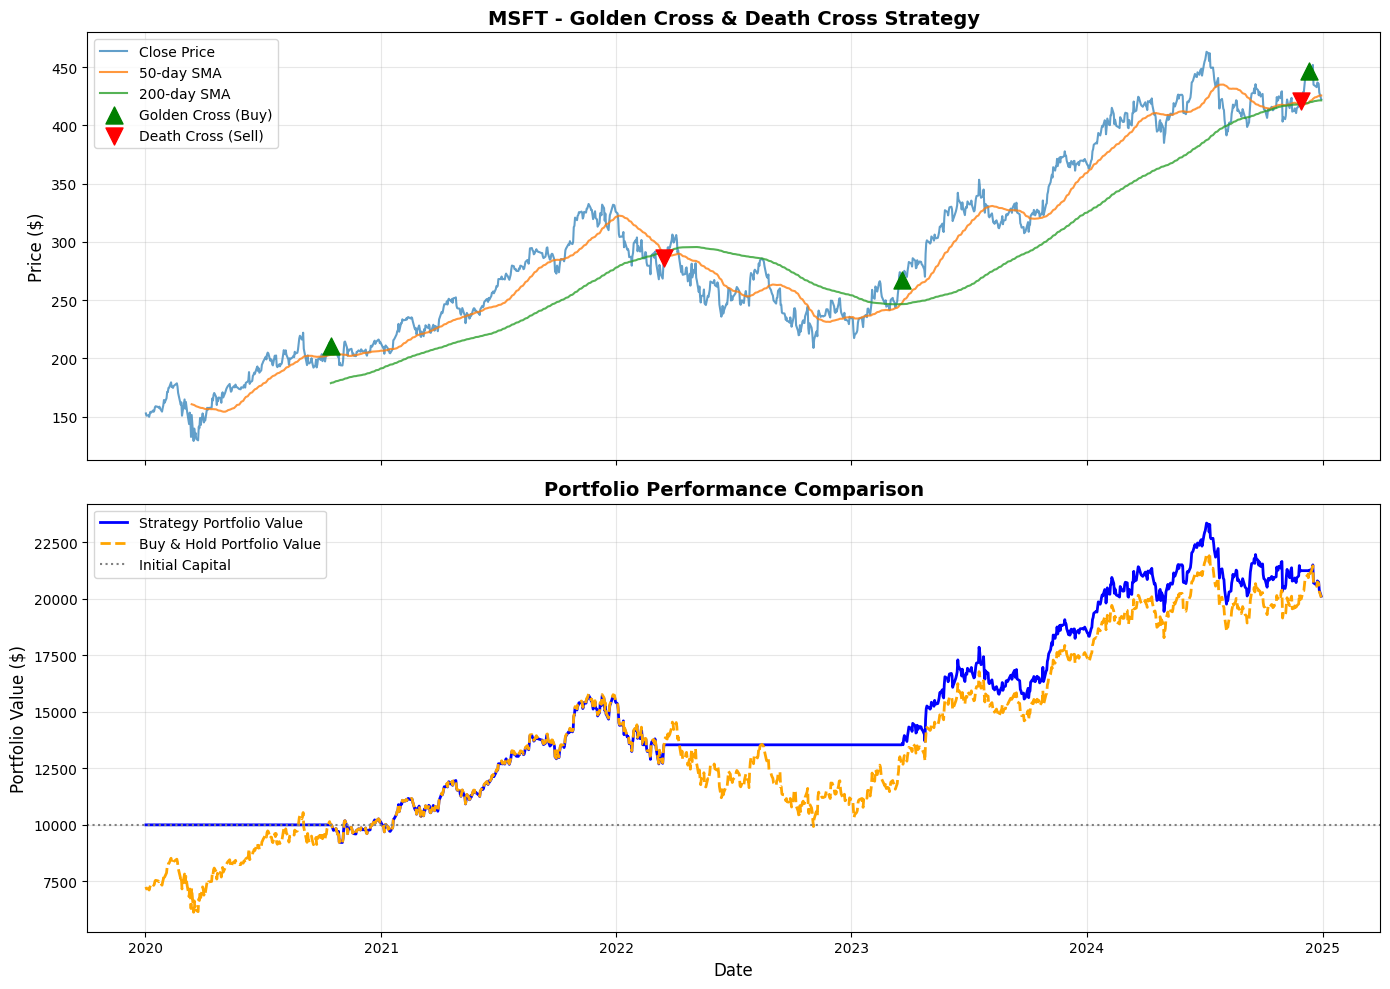


First few signals:
                 price   SMA_short    SMA_long  signal  positions
Date                                                             
2020-01-02  152.791122         NaN         NaN     0.0        NaN
2020-10-15  210.615601  203.174807  178.827158     1.0        1.0
2022-03-16  285.970001  290.347645  291.014593     0.0       -1.0
2023-03-20  267.038086  247.163878  246.595501     1.0        1.0
2024-11-29  421.145844  418.017926  418.213593     0.0       -1.0


In [12]:
# Set parameters
TICKER = 'MSFT'  # Change to any stock ticker
INITIAL_CAPITAL = 10000

# Create backtester instance
backtester = MovingAverageCrossBacktest(
    ticker=TICKER,
    data=close_prices[TICKER],
    short_window=50,
    long_window=200,
    initial_capital=INITIAL_CAPITAL,
    save_chart=True
)

# Run backtest
portfolio = backtester.run_full_backtest()
backtester.plot_results()
    
# Access results
print("\nFirst few signals:")
print(backtester.signals[backtester.signals['positions'] != 0].head())

## 3. Test Multiple Stocks for comparision

In [13]:
portfolio.tail()

,price,cash,total,returns,buy_hold
Date,,,,,
2024-12-23,432.871429,10000,20604.793610,-0.003053,20552.676451
2024-12-24,436.929108,10000,20795.504486,0.009256,20745.334460
2024-12-26,435.715790,10000,20738.478546,-0.002742,20687.726293
2024-12-27,428.177216,10000,20384.165558,-0.017085,20329.795817
2024-12-30,422.508362,10000,20117.729431,-0.013071,20060.639413


In [19]:
result_lst = []

for tick in tqdm(all_tickers):
    
    # Set parameters
    INITIAL_CAPITAL = 10000
    
    # Create backtester instance
    backtester = MovingAverageCrossBacktest(
        ticker=tick,
        data=close_prices[tick],
        short_window=50,
        long_window=200,
        initial_capital=INITIAL_CAPITAL,
        save_chart=False
    )
    
    # Run backtest
    portfolio = backtester.run_full_backtest()
    result_dict = {
        'Ticker':tick,
        'golden-death-cross_strategy': portfolio.iloc[-1]['total'],
        'buy-hold': portfolio.iloc[-1]['buy_hold'],
    }    
    result_lst.append(result_dict)

result_df = pd.DataFrame(result_lst)

  0%|          | 0/49 [00:00<?, ?it/s]

Positive means out-perform & negative means under-perform
 Out of 49 tests, 12(24.5%) out perfromed buy-and-hold 
and 37(75.5%) under performed


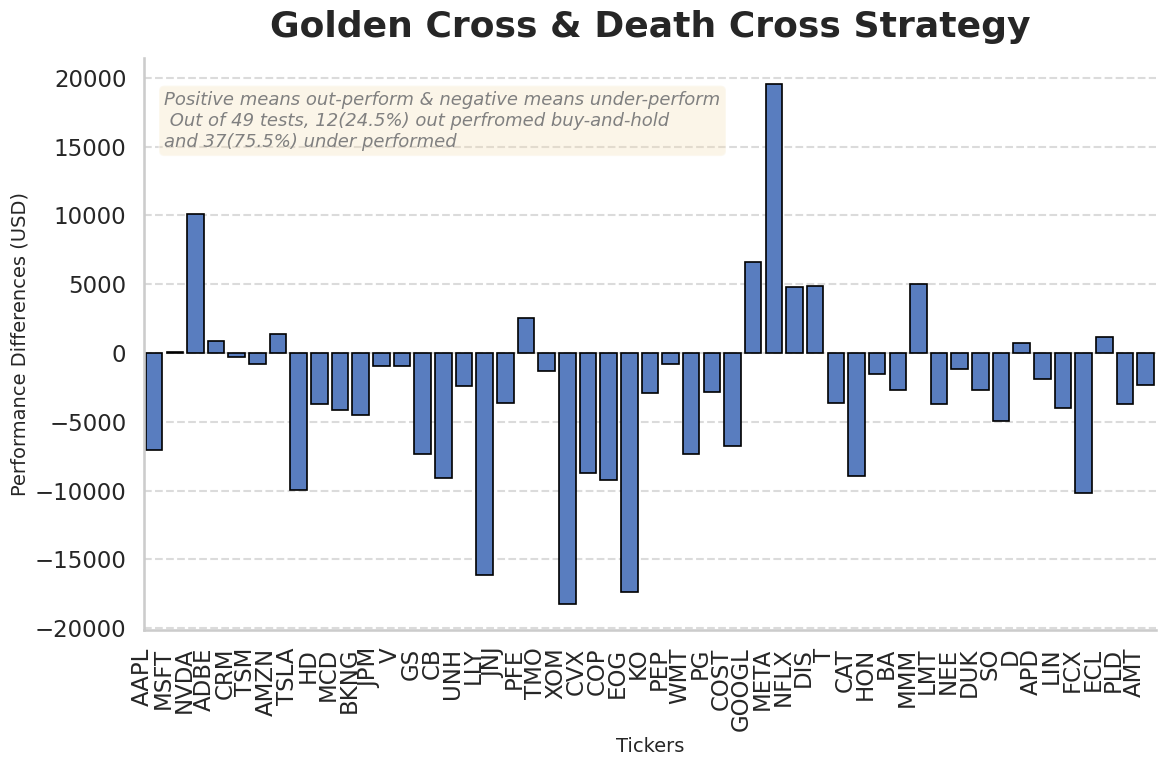

In [27]:
result_df['strate_diff'] = result_df['golden-death-cross_strategy'] - result_df['buy-hold']

over_perfom_ct = (result_df['strate_diff'] > 0 ).sum()
under_perfom_ct = (result_df['strate_diff'] < 0 ).sum()
total_ct = len(result_df)

 
print(annotate_text :=f"Positive means out-perform & negative means under-perform\n \
Out of {total_ct} tests, {over_perfom_ct}({100*over_perfom_ct/total_ct :,.1f}%) \
out perfromed buy-and-hold \nand {under_perfom_ct}({100*under_perfom_ct/total_ct :,.1f}%) under performed")
# visual here

# Set Seaborn theme
sns.set_theme(
    style="whitegrid",    # options: darkgrid, whitegrid, dark, white, ticks
    context="talk",       # options: paper, nkotebook, talk, poster
    palette="muted"       # color palette
)

# Create the bar plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=result_df,
    x="Ticker",
    y="strate_diff",
    # palette="coolwarm",    # override theme palette
    edgecolor="black",
    linewidth=1.2
)

# add anotnation here
ax.text(
    0.5, 15_000,                     # (x, y) position in figure coordinates (0–1)
    annotate_text, # Text content
    # ha='left', va='bottom',
    fontsize=13, color='gray', style='italic',
    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3)
)

# Customize labels and title
ax.set_title("Golden Cross & Death Cross Strategy", fontsize=26, fontweight='bold', pad=15)
ax.set_xlabel("Tickers", fontsize=14)
ax.set_ylabel("Performance Differences (USD)", fontsize=14)

# Customize axes and spines
sns.despine(top=True, right=True)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(rotation=90, ha='right')  # ha='right' aligns the labels neatly
# Show the final plot
plt.savefig('images/GD-Cross-Backtest-Results.png', dpi=100, bbox_inches='tight')
plt.tight_layout()

plt.show()
